# Bin syllables

This notebook is an interactive script that bins the syllable id sequences into fixed bin sizes.
Bin sizes are chosen based on the analyses of minimum bin size, $n_\textrm{min}$, to achieve a worst case parameter estimation error $\epsilon_\textrm{max}$ with 95% confidence level.

Specifically, we choose to tolerate $\epsilon_\textrm{max} = 0.02$ error.
This can be achieved by choosing $n_\textrm{min}=2400 \textrm{frames} = 1.33 \textrm{min}$.
We round this bin size down to $n_\textrm{min}=1800 \textrm{frames} = 1 \textrm{mn}$ for convenience, which could have a worst case error of $\epsilon_\textrm{max} = 0.022$.

We bin the syllable id sequences into these 1 minute bins, examine their the resulting binned sequences, and save the binned data as `syllable_binned_1min.npz` with 
elements
- `session_syllable_counts`: int array, shape `(n_sessions, n_bins, n_syllables)`.
    - The outlier syllables have excluded, the counts have been normalized to sum exactly to `bin_size` (although this constraint is not necessary), and the syllables have been permuted according to feature similarity clusters.
- `session_drug_name`: shape `(n_sessions,)`, string type
- `session_drug_class`: shape `(n_sessions)`, string dtype
- `session_drug_dose_0to6`: shape `(n_sessions)`, string dtype
    - Same as arrays of same name in `syllable_sequence_data.npz`
- `syllable_cluster`: shape `(n_syllables,)`, string dtype
    - Cluster name associated with each syllable
    - Same as `perm_syllable_cluster` in `syllable_sequence_data.npz`
- `meta_bin_size`: int
    - Bin size
- `meta_fps`: int
    - Frames per second
where `n_sessions = 500`, `n_bins=20`, and `n_syllables=90`.

In [1]:
from pathlib import Path
import time

import itertools
from jax import lax, vmap
import jax.numpy as jnp
import jax.random as jr
import numpy as np
import optax

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

from dtd.model3d import DirichletTuckerDecomp
# from kf_viz import draw_syllable_factors, draw_circadian_bases

### Load data

In [2]:
DATASET_DIR = "/home/groups/swl1/eyz/data/moseq-drugs/"

filepath = DATASET_DIR + "syllable_sequence_data.npz"

data = {}
with np.load(filepath) as f:
    session_syllables = f['session_syllables']
    session_drug_name = f['session_drug_name']
    session_drug_class = f['session_drug_class']
    session_drug_dose_0to6 = f['session_drug_dose_0to6']
    perm_syllable_id = f['perm_syllable_id']
    perm_syllable_cluster = f['perm_syllable_cluster']

print(f"session_syllables:\tshape={session_syllables.shape}, dtype={session_syllables.dtype}")

# --------------------------------------------------------------------------------------------
n_sessions, session_length = session_syllables.shape
n_syllables = 90
fps = 30

session_syllables:	shape=(500, 36000), dtype=uint8


### Helper plotting functions

**Label axis with syllable cluster names**

In [3]:
# Get unique cluster names (sorted alphanumerically), their first index in
# the dataset, and number of instances per cluster.
cluster_names, cluster_idxs, cluster_counts \
    = np.unique(perm_syllable_cluster, return_index=True, return_counts=True)

# Sort cluster names and counts in the order that they were seen
cluster_idxs = np.argsort(cluster_idxs)
cluster_names = [str(cluster_names[i]) for i in cluster_idxs]
cluster_counts = np.array([cluster_counts[i] for i in cluster_idxs])

# Set bounding edges and label tick location
cluster_edges = np.cumsum(cluster_counts)
cluster_ticks = np.cumsum(cluster_counts) - cluster_counts/2

def set_syllable_cluster_ticks(ax, axis='x', label=True, fontsize='xx-small'):
    """Set syllable cluster ticks and tick labels.
    
    Parameters
        ax (mpl.axes.Axes): Axes to label
        label (bool): If true, label ticks. Else, just draw boundaries.

    """

    if axis == 'x':
        # Break long cluster names into two lines
        labels = [lbl.replace(" ", "\n") for lbl in cluster_names]

        # Set boundary ticks; extend tick length
        ax.set_xticks(cluster_edges[:-1]-0.5, minor=True)
        ax.tick_params(axis='x', which='minor', length=18)

        # Set labels
        if label:
            ax.set_xticks(cluster_ticks)
            ax.set_xticklabels(labels, ha='center', va='center', fontsize=fontsize)
            
            # Hide label tick, add padding from axis
            ax.tick_params(axis='x', which='major', length=0, pad=10)
        else:
            ax.tick_params(axis='x', which='major', bottom=False, labelbottom=False)
    
    elif axis == 'y':
        # Keep cluster names in a single line
        labels = cluster_names

        # Set boundary ticks; extend tick length
        ax.set_yticks(cluster_edges[:-1]-0.5, minor=True)

        # Set labels
        if label:
            ax.tick_params(axis='y', which='minor', length=18)  # Set long cluster dividers

            ax.set_yticks(cluster_ticks)
            ax.set_yticklabels(labels, ha='right', va='center', fontsize=fontsize)
            # Hide label tick, add padding from axis
            ax.tick_params(axis='y', which='major', length=0, pad=5)
        else:
            ax.tick_params(axis='y', which='minor', length=9)  # Set short cluster tick dividers
            
            ax.tick_params(axis='y', which='major', left=False, labelleft=False)

    else:
        print(f"WARNING: axis {axis} not recognized. Expected one of 'x' or 'y'.")
    
    return

**Label axis with session time ticks**

In [4]:
def set_session_time_ticks(ax,
                           bin_size,
                           period_min=5,
                           length_min=20,
                           fps=30,
                           label=True,
                           axis='x',
                           fontsize='xx-small',
                           include_end=True):
    """Set within-session time ticks and tick labels.
    
    Parameters
        ax (mpl.axes.Axes)
        bin_size (int): Bin size of data, in units of frames.
        period_min (float): Time between ticks, in units of minutes.
        length_min (float): Length of session, in units of minutes
        fps (int). Frames per second.
        label (bool): If True, label ticks.
        include_end (bool): If True, include the last tick indicating session length.
    """

    # Include end of session length
    tick_labels = np.arange(0, length_min+include_end, period_min)
    ticks = tick_labels * 60 * fps / bin_size - 0.5

    if axis == 'x':
        ax.set_xticks(ticks)
        if label:
            ax.set_xticklabels(tick_labels, fontsize=fontsize)

    elif axis == 'y':
        ax.set_yticks(ticks)
        if label:
            ax.set_yticklabels(tick_labels, fontsize=fontsize)

    else:
        print(f"WARNING: axis {axis} not recognized. Expected one of 'x' or 'y'.")
    
    return

## Bin syllables

In [5]:
def count_states_in_a_sequence(state_seq, n_states):
    """Count number of occurences of each state in a sequence.

    Equivalent to representing as one-hot vectors and summing, 
        `np.eye(n_states)[:, state_seq].sum(axis=-1)`,
    but more memory efficient and JAX friendly.

    Parameters
        state_seq: shape (N,), int array
            Sequence of token indices, values ranging from [0, n_states)
        n_states: int
            Number of unique states
                
    Return
        counts: shape (n_states,), int array
            Number of occurences of each state; counts.sum() == N,
    """

    init_counts = jnp.zeros(n_states, dtype=int)

    def _count(carry, x):
        return carry.at[x].add(1), None
    
    counts, _ = lax.scan(_count, init_counts, xs=state_seq)

    return counts

def bin_and_count_states_in_a_sequence(state_seq, n_states, bin_size, bin_overlap_frac=0.):
    """Bin state sequence and count number of occurences in each bin.
    
    Parameters
        state_seq: shape (L,), int array
            Sequence of token indices, values ranging from [0, n_states)
        n_states: int
            Number of unique states
        bin_size: int
            Number of samples per bin.
        bin_overlap_frac: float
            Fraction overlap between bins, between 0 and 1.
            Value of 0 result in no overlap. Value of 1 (or close to 1)
            will result in a true sliding window.
                
    Return
        counts: shape (n_bins, n_states,), int array
            Number of occurences of each state per bin, where
            `n_bins == L // bin_size` and `counts.sum() == bin_size`.
    """

    stride = max(int(bin_size * (1-bin_overlap_frac)), 1)
    
    # Count occurences of each state id in the bin
    start_idxs = jnp.arange(0, len(state_seq) - bin_size + 1, stride)
    state_counts = vmap(
        lambda start: count_states_in_a_sequence(
            lax.dynamic_slice(state_seq, (start,), (bin_size,)),
            n_states
        )
    )(start_idxs)  # shape (n_bins, n_states)

    return state_counts

def standardize_counts(key, init_counts, probs, add_vec,):
    """Randomly add counts to a vector.

    Parameters
        key: PRNGKey
        init_counts: shape (n_states,), int array
        probs: shape (n_states,) float array
            Probability of adding count to a state. If None, assume uniform distribution.
        add_vec: shape (n_padded,), int array
            Binary / boolean array indicate whether to add a count.
            Total number of counts, n = add_vec.sum() <= n_padded
        
    Return
        standardized_counts: shape (n_states,), int array
    """
    def _sample(carry, xs):
        counts = carry
        key, add = xs

        new_id = jr.choice(key, len(probs), p=probs)
        counts = counts.at[new_id].add(add)

        return counts, None

    new_counts, _ = lax.scan(_sample, init_counts, xs=(jr.split(key, len(add_vec)), add_vec))

    return new_counts

def bin_state_sequences(state_sequences,
                        n_states,
                        bin_size,
                        n_outlier_states=1,
                        bin_overlap_frac=0,
                        key=None):
    """Bin a batch of state sequences, discard outliers, and restandardize counts.

    Discards outliers or other tokens with indices greater or equal to `n_states`.
    Renormalize bin count so total number of tokens sums to orignal sequence length,
    with probability proportional to empirical frequency.

    This function is not jittable because of variable number of missing counts
    when renormalizing the bins. However, it jit's smaller functions where possible.

    Parameters
        state_sequences: shape (..., L), int array
            Sequence of token indices, with values in the sets
            [0, n_states) U [n_states, n_states+n_outlier_states).
        n_states: int
            Number of unique "inlier" states. These will be included.
        bin_size: int
            Number of frames per bin.
        n_outlier_states: int
            Number of unique "outlier" states. These will be excluded.
        bin_overlap_frac: float
            Fraction overlap between bins, between 0 and 1.
            Value of 0 result in no overlap. Value of 1 (or close to 1)
            will result in a true sliding window.
        seed: PRNGKey
            Used to renormalize bin count to sum to `bin_size`; needed after
            removing outlier states in a bin.
                
    Return
        counts: shape (..., n_bins, n_states,) int array
            Number of occurencs of each state in the bin, where
            `n_bins == L // bin_size` and `counts.sum() == bin_size`.
    """

    batch_shape, seq_len = state_sequences.shape[:-1], state_sequences.shape[-1]
    n_bins = seq_len // bin_size

    # ---------------------------------------------------------------------------
    # Bin sequences
    # ---------------------------------------------------------------------------
    # Bin each sequence and count, shape (batch_size, n_bins, n_states+n_outlier_states)
    binned_state_counts = vmap(
        lambda seq: bin_and_count_states_in_a_sequence(
            seq, n_states+n_outlier_states, bin_size, bin_overlap_frac
    ))(state_sequences.reshape(-1, seq_len))

    batch_size = len(binned_state_counts)  # == prod(*batch_shape)

    # ---------------------------------------------------------------------------
    # Remove outliter state ids
    # ---------------------------------------------------------------------------
    # Discard excluded ids
    binned_state_counts = binned_state_counts[...,:n_states]  # shape (batch_size, n_bins, n_states)

    # Flatten along bin axis as well
    binned_state_counts = binned_state_counts.reshape(-1, n_states) # shape (batch_size * n_bins, n_states)

    # Convert counts to frequency. Since we excluded the outlier ids,
    # the state probabilities do not sum to 1, so we renormalize
    binned_state_probs = binned_state_counts / binned_state_counts.sum(axis=-1, keepdims=True)

    # Convert back to counts. These will not necessarily add up exactly to bin_size
    binned_state_counts = jnp.asarray(binned_state_probs * bin_size, dtype=int)  # effectively, jnp.floor
    
    # ---------------------------------------------------------------------------
    # Restandardize bins so that they each count bin_size event counts
    # ---------------------------------------------------------------------------
    # Figue out how many counts each bin is missing
    diffs = bin_size - binned_state_counts.sum(axis=-1)  # shape (batch_size*n_bins,)
    max_n_missing = diffs.max()

    # Construct padded add/no-add vector with numpy array for faster and in-place updates
    add_flags = np.zeros((batch_size*n_bins, max_n_missing), dtype=int)
    for i, n_missing in enumerate(diffs):
        add_flags[i, :n_missing] += 1
    add_flags = jnp.asarray(add_flags, dtype=int)

    # Finally, standardize
    standardized_counts = vmap(standardize_counts)(
        jr.split(key, batch_size*n_bins),
        binned_state_counts,
        binned_state_probs,
        add_flags,
    )
    return standardized_counts.reshape(*batch_shape, n_bins, n_states)


In [6]:
bin_size = 60 * 30  # 60s x 30 fps bin size
bin_size_text = '1 min'
session_counts = bin_state_sequences(session_syllables, n_syllables, bin_size, key=jr.key(0))
session_counts = session_counts[..., perm_syllable_id]  # permute syllable ids

### Visualize

In [7]:
session_freqs = session_counts / session_counts.sum(axis=-1, keepdims=True)

**Plot single sessions**

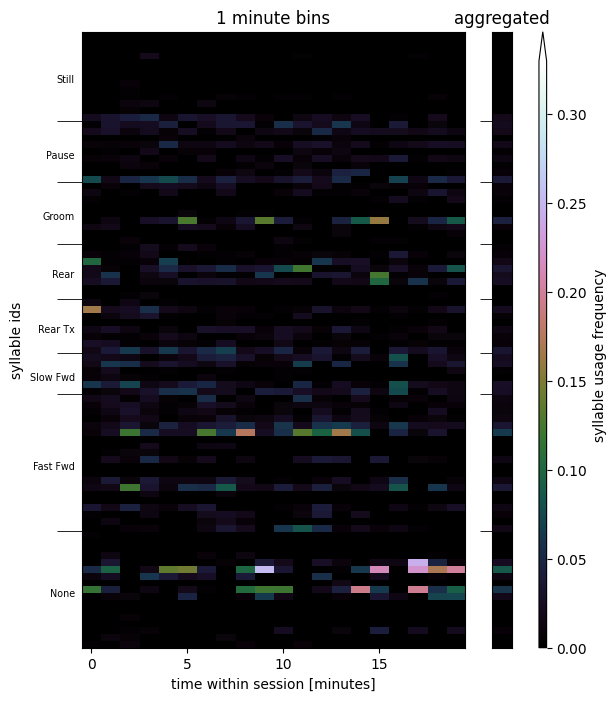

In [8]:
# Plot within-session binned dynamics vs. aggregated syllable usage frequency
i_session = -1

bin_freqs = session_freqs[i_session]  # shape (n_bins, n_states)
agg_freqs = session_freqs[i_session].sum(axis=0) / session_freqs[i_session].sum()

# vmax = np.percentile(session_freqs, 99)  # share clims across all sesions
vmax = 0.33
imshow_kwargs = dict(
    cmap='cubehelix', vmin=0, vmax=vmax, interpolation='none', aspect='auto'
)

fig, (ax_bin, ax_agg, cax) = plt.subplots(
    nrows=1,
    ncols=3, width_ratios=[10, 0.5, 0.2],
    figsize=(6,8)
)

# ----------------------------------------------
# Show binned syllable frequency
# ----------------------------------------------
ax = ax_bin
im = ax.imshow(bin_freqs.T, **imshow_kwargs)

# title
ax.set_title('1 minute bins')

# x-axis: time within session
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.set_xlabel("time within session [minutes]")

# y-axis: syllable ids
ax.set_ylabel("syllable ids")
set_syllable_cluster_ticks(ax, axis='y', fontsize='x-small')

# ----------------------------------------------
# Show aggregated syllable frequency
# ----------------------------------------------
ax = ax_agg
ax.imshow(np.atleast_2d(agg_freqs).T, **imshow_kwargs)

# title
ax.set_title('aggregated')

# x-axis: none
ax.set_xticks([])

# y-axis: syllable ids, shared with left subplot
set_syllable_cluster_ticks(ax, axis='y', label=False)

# ----------------------------------------------
# Show colorbar
# ----------------------------------------------
plt.colorbar(im, cax=cax, extend='max', label='syllable usage frequency')

**Plot by syllables**

In [9]:
# Make name-and-dose labels and ticks
name_and_dose = [f"{drug}-{dose}" for drug, dose in zip(session_drug_name, session_drug_dose_0to6)]
_, idx_name_and_dose, name_and_dose_counts = np.unique(name_and_dose, return_index=True, return_counts=True)

# Ensure that name x dose names and counts are in the original order
unique_name_and_dose = [name_and_dose[i] for i in sorted(idx_name_and_dose)]
name_and_dose_counts = np.array([name_and_dose_counts[i] for i in np.argsort(idx_name_and_dose)])

name_and_dose_edges = np.cumsum(name_and_dose_counts)
name_and_dose_ticks = np.cumsum(name_and_dose_counts) - name_and_dose_counts / 2

# ---------------------------------------------------------------------------
# Make drug class labels and ticks
_, idx_classes, class_counts = np.unique(session_drug_class, return_index=True, return_counts=True)

# Ensure that class labels and counts are in the original order
unique_classes = [session_drug_class[i] for i in sorted(idx_classes)]
class_counts = np.array([class_counts[i] for i in np.argsort(idx_classes)])

class_edges = np.cumsum(class_counts)
class_ticks = np.cumsum(class_counts) - class_counts/2

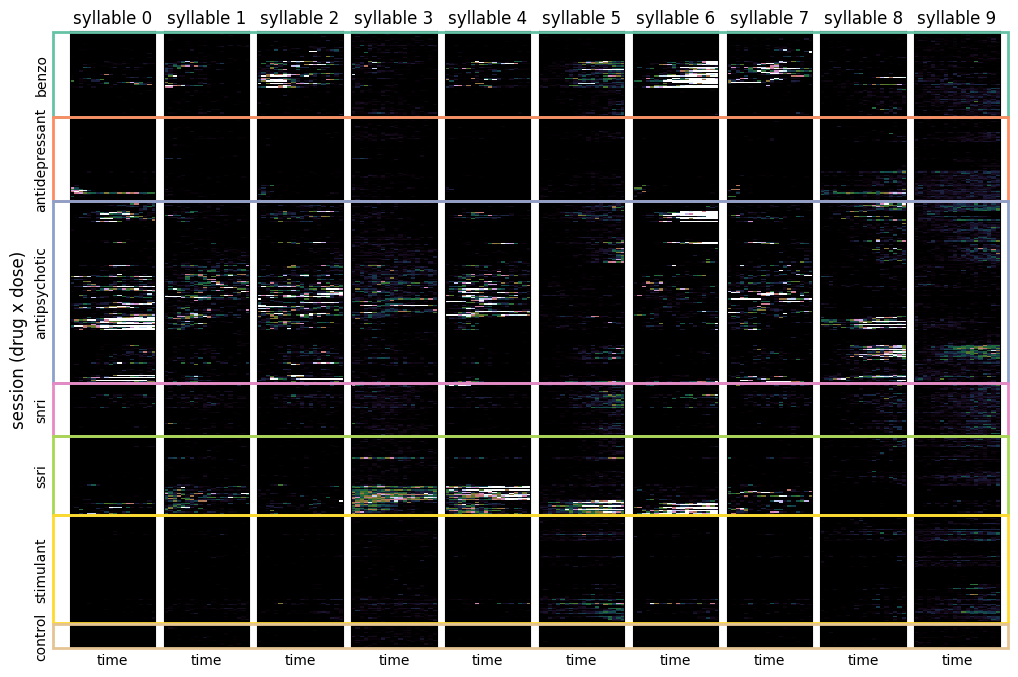

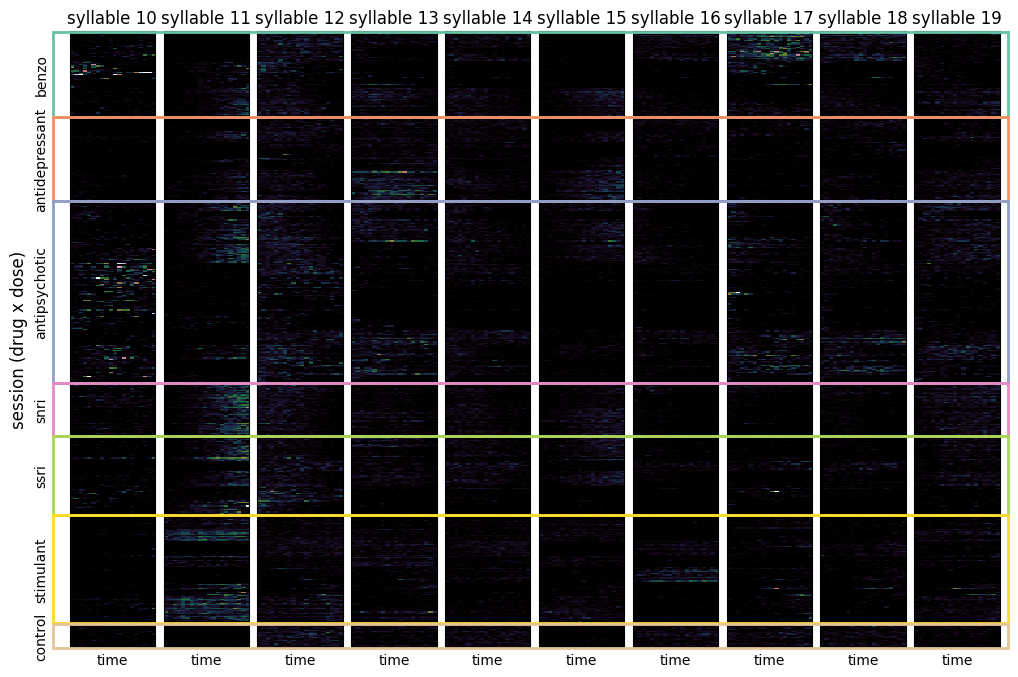

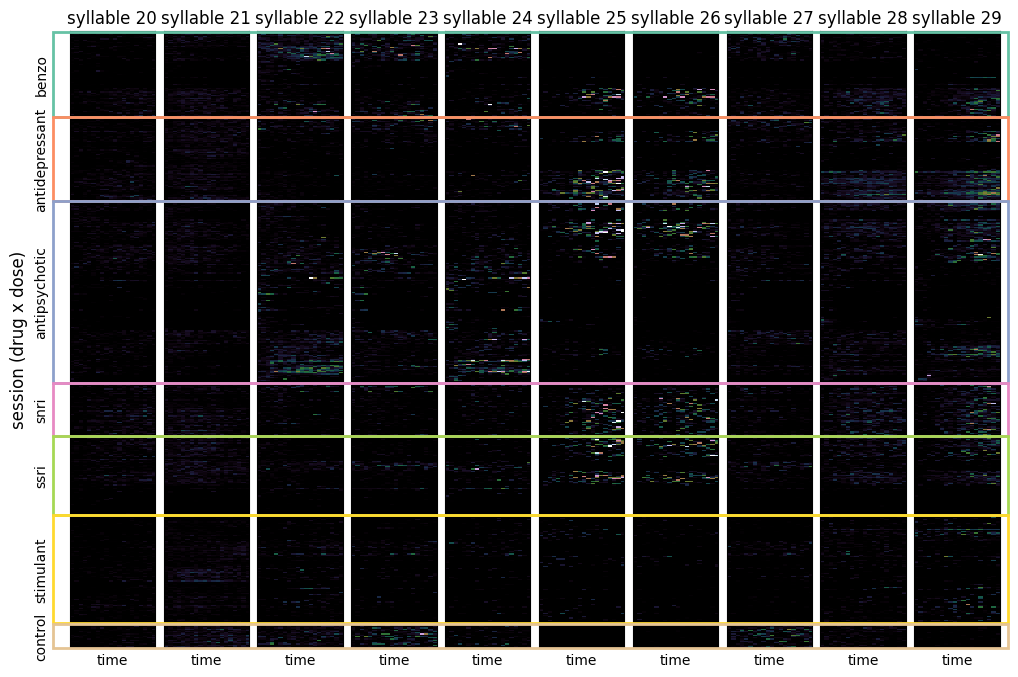

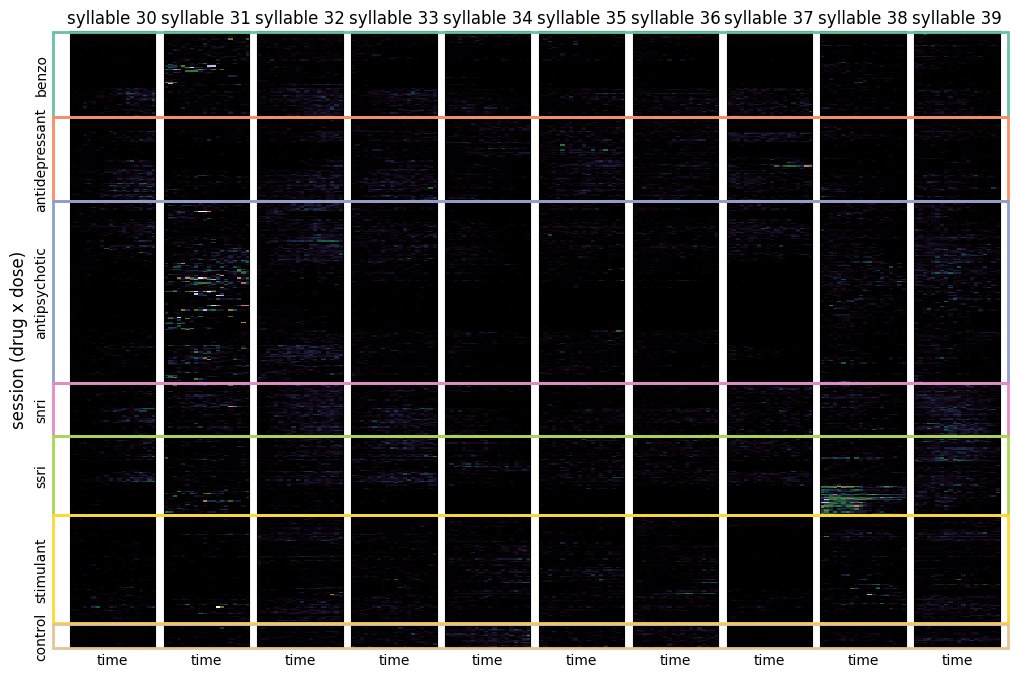

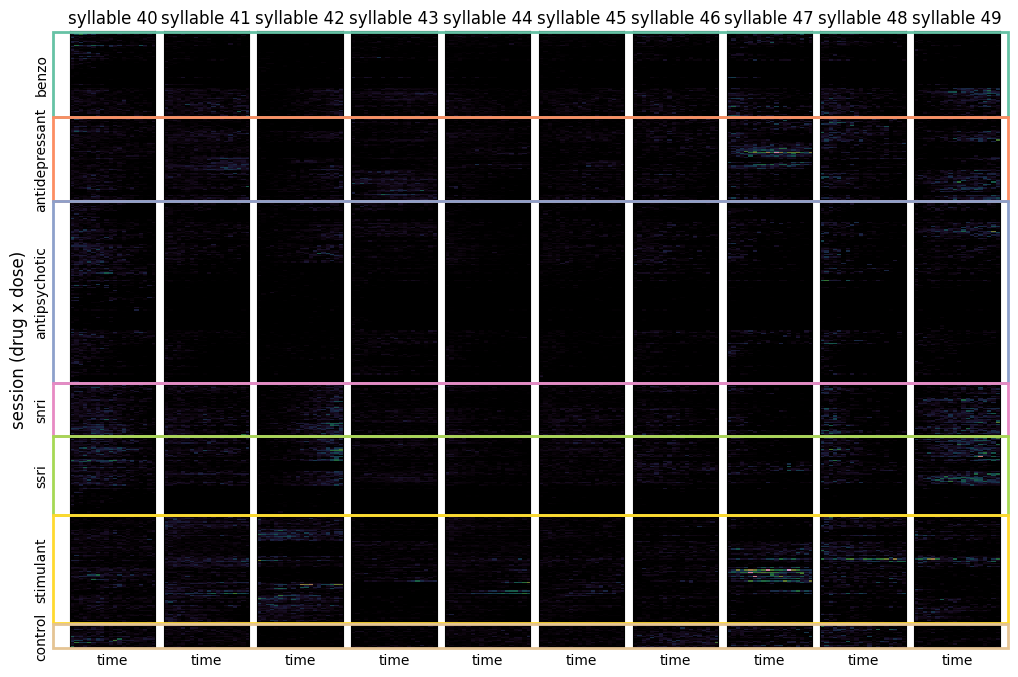

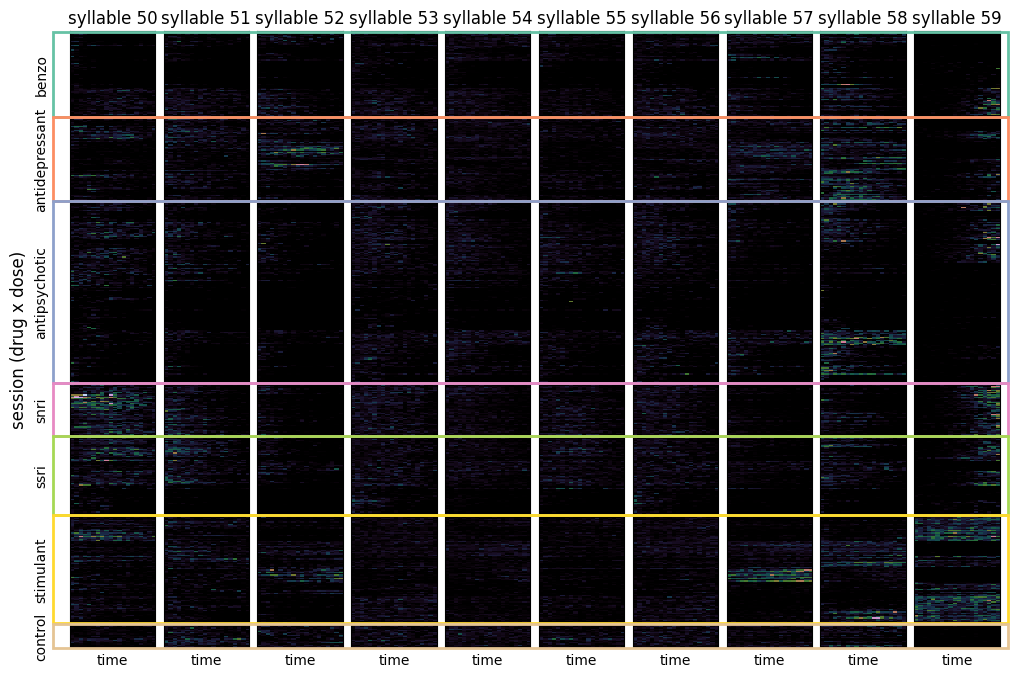

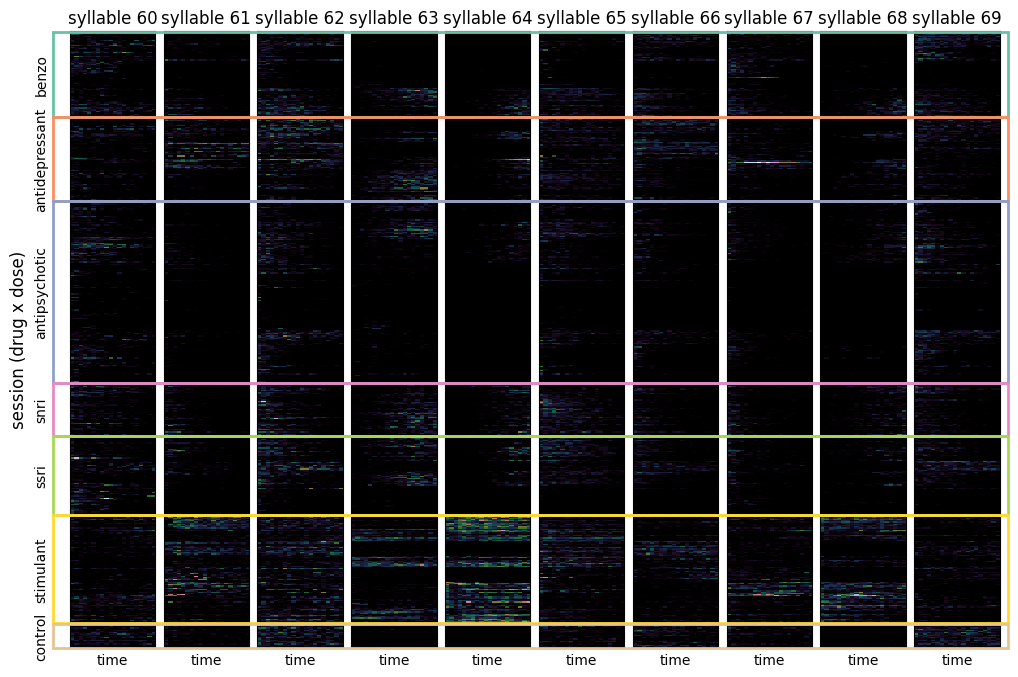

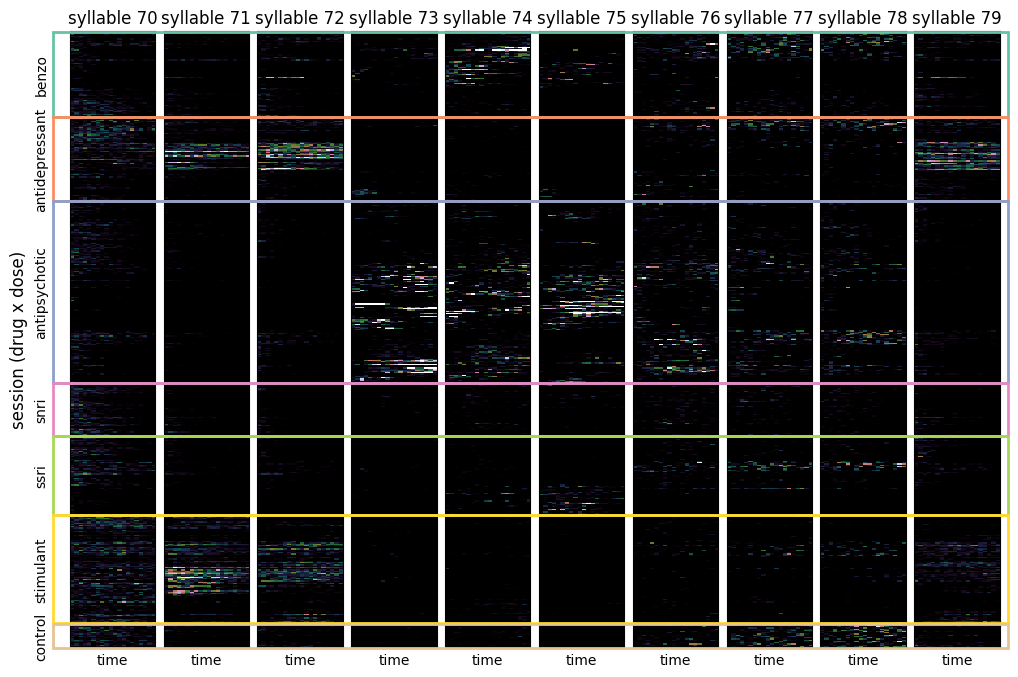

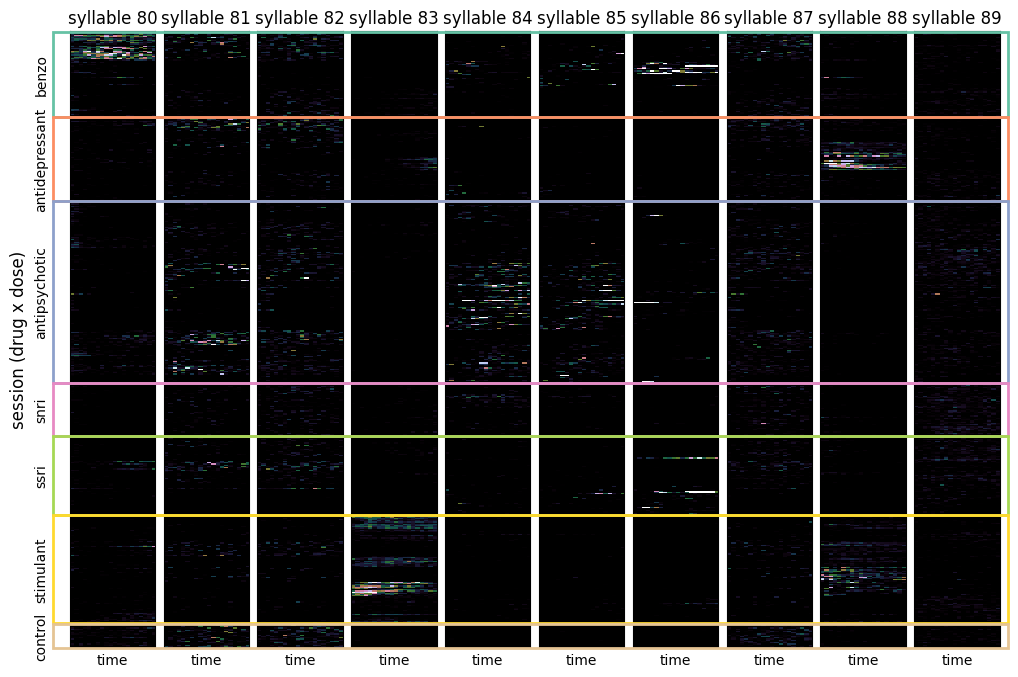

In [10]:
bin_size_text = '1 min'

ncols = 10

vmin = 0
# vmax = 0.33  # Using Wiltschko color mapping, sqrt
vmax = np.percentile(session_freqs, 99.9)

for ii in range(n_syllables // ncols):
    fig, axs = plt.subplots(nrows=1, ncols=ncols, gridspec_kw=dict(wspace=0.1), figsize=(12,8), sharey=True)

    for i, ax in enumerate(axs):
        ax.imshow(
            # np.sqrt(session_freqs[:,:,i+ii*ncols]),  # Wiltschko color mapping
            session_freqs[:,:,i+ii*ncols],
            cmap='cubehelix', vmin=0, vmax=vmax,
            interpolation='none', aspect='auto'
        )

        ax.set_title(f"syllable {i+ii*ncols}")
        ax.set_xlabel(f"time")
        ax.set_xticks([])

    # -------------------------------------------------------------
    # Draw outermost rectangle: drug class
    ax = axs[-1]

    x0 = -10.1
    width = 11.2
    for i_class, color in enumerate(mpl.colormaps['Set2'].colors[:len(unique_classes)]):
        y0 = class_edges[i_class-1] if i_class > 0 else 0
        y1 = class_edges[i_class]
        
        rect = Rectangle(
            (x0, y0+0.1), width, y1-y0-0.2,
            transform=ax.get_yaxis_transform(),
            lw=2, ec=color, fc='none', clip_on=False, zorder=20)
        ax.add_patch(rect)

        ax.text(x0-0.05, y0 + (y1-y0)/2, unique_classes[i_class],
            va='center', ha='right', rotation=90,
            transform=ax.get_yaxis_transform(),
            clip_on=False
        )

    ax = axs[0]
    ax.set_ylabel("session (drug x dose)", fontsize='large', labelpad=30, va='bottom')
    ax.set_yticks([]);

    plt.show()

## Save binned data

In [11]:
dest_path = DATASET_DIR + f"syllable_binned_{bin_size_text}.npz"

# Uncomment to save
# np.savez(
#     dest_path,
#     session_syllable_counts = session_counts,
#     session_drug_name = session_drug_name,
#     session_drug_class = session_drug_class,
#     session_drug_dose_0to6 = session_drug_dose_0to6,
#     syllable_cluster = perm_syllable_cluster,
#     meta_bin_size=bin_size,
#     meta_fps=fps,
# )

In [12]:
# Verify save
with np.load(dest_path) as f:
    for key in list(f):
        print(f"{key}:\tshape={f[key].shape}, dtype={f[key].dtype}")

session_syllable_counts:	shape=(500, 20, 90), dtype=int32
session_drug_name:	shape=(500,), dtype=<U4
session_drug_class:	shape=(500,), dtype=<U14
session_drug_dose_0to6:	shape=(500,), dtype=uint8
syllable_cluster:	shape=(90,), dtype=<U8
meta_bin_size:	shape=(), dtype=int64
meta_fps:	shape=(), dtype=int64
